In [ ]:
# Activate "amyloid" env
import sys
print(sys.executable)

/opt/anaconda3/envs/amyloid/bin/python


## Geometric Parameters of Protofilaments

## Protofilament Twist per Chain (°)
**Definition:**

Protofilament twist per chain refers to the angular rotation between adjacent peptide chains (β-strands) within a protofilament along the fibril axis. This parameter quantifies how much each chain is rotated relative to its neighboring chain in the β-sheet structure.

**Formula:**

The twist per chain ($\theta$) can be calculated as:

$$
\theta = (\theta_{n+1} - \theta_n)
$$

**Where:**

- $\theta_n$ represents the orientation angle of the n-th peptide chain in the fibril.
- $\theta_{n+1}$ represents the orientation angle of the adjacent (n+1)-th peptide chain.

The twist is typically measured in degrees and is generally left-handed in amyloid structures. The accumulated twist along multiple chains contributes to the overall helical structure of the fibril. This parameter is fundamental to the long-range twist observed in mature fibrils, as "the β-sheets in amyloid protofilaments must accompany the overall fibril twist".

---

## Protofilament Rise per Chain (Å)
**Definition:**

Protofilament rise per chain represents the vertical displacement (along the fibril axis) between adjacent peptide chains in a protofilament. This parameter measures the distance between consecutive β-strands in the direction of the fibril axis.

**Formula:**

The rise per chain ($\Delta z$) can be expressed as:

$$
\Delta z = |z_{n+1} - z_n|
$$

**Where:**

- $z_n$ is the position along the fibril axis of the projected centroid of the \(n\)-th peptide chain.
- $z_{n+1}$ is the position of the projected centroid of the adjacent (n+1)-th peptide chain.

In typical amyloid structures, the rise per chain corresponds to the separation between β-strands and is approximately 4.8 Å, which represents the characteristic distance in the cross-β structural repeat. This dimension is consistently observed in X-ray diffraction patterns of various amyloid fibrils, representing one of the defining features of amyloid structures.

---

## RMSD of α-Carbons from Best-Fit Plane (Å)
**Definition:**

This parameter quantifies the planarity of the β-sheets within the protofilament by measuring how much the α-carbon atoms deviate from a theoretical flat plane. It provides insight into the flatness of the β-sheet structure, which is critical for understanding protofilament assembly.

**Formula:**

The RMSD of α-carbons from the best-fit plane can be calculated as:

$$
\text{RMSD} = \sqrt{\frac{\sum_i d_i^2}{N}}
$$

**Where:**

- $d_i$ is the perpendicular distance of the \(i\)-th α-carbon atom from the best-fit plane.
- $N$ is the total number of α-carbon atoms considered.

The best-fit plane is determined using mathematical methods such as principal component analysis or least-squares fitting.

Lower RMSD values indicate flatter β-sheets, which is consistent with observations that "β-sheets in amyloid protofilaments must accompany the overall fibril twist (and thus be nearly flat)". This parameter is crucial for distinguishing amyloid fibril structures from the highly twisted β-sheets often observed in globular proteins.

---

## Tilt of Layer Normal from Fibril Axis (°)
**Definition:**

The tilt of layer normal from fibril axis represents the angle between the normal vector to the β-sheet plane and the central fibril axis. This parameter describes how the β-sheets are oriented relative to the main axis of the fibril.

**Formula:**

The tilt angle ($\varphi$) can be calculated as:

$$
\varphi = \cos^{-1}(\hat{n} \cdot \hat{a})
$$

**Where:**

- $\hat{n}$ is the unit normal vector to the β-sheet plane.
- $\hat{a}$ is the unit vector along the fibril axis.
- $\cdot$ represents the dot product.

As noted in one of the search results, this can also be understood as "the average absolute angle between the backbone and the plane perpendicular to the fibril axis". The tilt angle provides critical information about the packing geometry of β-sheets within the protofilament and influences the overall structural stability of the fibril.


In [ ]:
import re
import pandas as pd
from pathlib import Path

def parse_sheet_records_full(pdb_file_path):
    with open(pdb_file_path, 'r') as f:
        pdb_lines = f.readlines()

    sheet_data = []

    for line in pdb_lines:
        if not line.startswith("SHEET"):
            continue
        try:
            strand_no = int(line[7:10].strip())
            sheet_id = line[11:14].strip()
            num_strands = int(line[14:16].strip())
            start_resname = line[17:20].strip()
            start_chain = line[21].strip()
            start_resid = int(line[22:26].strip())
            start_icode = line[26].strip()

            end_resname = line[28:31].strip()
            end_chain = line[32].strip()
            end_resid = int(line[33:37].strip())
            end_icode = line[37].strip()

            sense = int(line[38:40].strip())

            # Optional registration (may be blank for first strand)
            donor_atom = line[41:45].strip() or None
            donor_resname = line[45:48].strip() or None
            donor_chain = line[49].strip() or None
            donor_resid_str = line[50:54].strip()
            donor_resid = int(donor_resid_str) if donor_resid_str else None
            donor_icode = line[54].strip() or None

            acceptor_atom = line[56:60].strip() or None
            acceptor_resname = line[60:63].strip() or None
            acceptor_chain = line[64].strip() or None
            acceptor_resid_str = line[65:69].strip()
            acceptor_resid = int(acceptor_resid_str) if acceptor_resid_str else None
            acceptor_icode = line[69].strip() or None

            offset = donor_resid - acceptor_resid if donor_resid is not None and acceptor_resid is not None else None

            sheet_data.append({
                "Amyloid": Path(pdb_file_path).stem,
                "StrandNo": strand_no,
                "SheetID": sheet_id,
                "NumStrands": num_strands,
                "StartResname": start_resname,
                "StartChain": start_chain,
                "StartResid": start_resid,
                "StartICode": start_icode,
                "EndResname": end_resname,
                "EndChain": end_chain,
                "EndResid": end_resid,
                "EndICode": end_icode,
                "Sense": sense,
                "OrientationLabel": {1: "Parallel", -1: "Antiparallel", 0: "Unknown"}.get(sense, "Unknown"),
                "DonorAtom": donor_atom,
                "DonorResname": donor_resname,
                "DonorChain": donor_chain,
                "DonorResid": donor_resid,
                "DonorICode": donor_icode,
                "AcceptorAtom": acceptor_atom,
                "AcceptorResname": acceptor_resname,
                "AcceptorChain": acceptor_chain,
                "AcceptorResid": acceptor_resid,
                "AcceptorICode": acceptor_icode,
                "Offset": offset,
                "Register": (
                    "In-register" if offset is not None and abs(offset) <= 2
                    else "Out-of-register" if offset is not None
                    else None
                )
            })

        except Exception as e:
            print(f"Skipping malformed SHEET line: {line.strip()}  ({e})")


    return pd.DataFrame(sheet_data)

    
df = parse_sheet_records_full("/Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/2rnm.pdb")
df

,Amyloid,StrandNo,SheetID,NumStrands,StartResname,StartChain,StartResid,StartICode,EndResname,EndChain,...,DonorChain,DonorResid,DonorICode,AcceptorAtom,AcceptorResname,AcceptorChain,AcceptorResid,AcceptorICode,Offset,Register
0,2rnm,1,A,10,SER,A,227,,THR,A,...,None,NaN,None,None,None,None,NaN,None,NaN,None
1,2rnm,2,A,10,THR,A,261,,GLY,A,...,A,267.0,None,N,ARG,A,232.0,None,35.0,Out-of-register
2,2rnm,3,A,10,ARG,B,225,,THR,B,...,B,231.0,None,N,VAL,A,268.0,None,-37.0,Out-of-register
3,2rnm,4,A,10,THR,B,261,,GLY,B,...,B,267.0,None,N,ARG,B,232.0,None,35.0,Out-of-register
4,2rnm,5,A,10,ASN,C,226,,THR,C,...,C,233.0,None,N,VAL,B,268.0,None,-35.0,Out-of-register
5,2rnm,6,A,10,ASN,C,262,,GLY,C,...,C,267.0,None,N,ARG,C,232.0,None,35.0,Out-of-register
6,2rnm,7,A,10,ASN,D,226,,THR,D,...,D,233.0,None,N,VAL,C,268.0,None,-35.0,Out-of-register
7,2rnm,8,A,10,SER,D,263,,GLY,D,...,D,264.0,None,N,LYS,D,229.0,None,35.0,Out-of-register
8,2rnm,9,A,10,ASN,E,226,,THR,E,...,E,233.0,None,N,VAL,D,268.0,None,-35.0,Out-of-register
9,2rnm,10,A,10,ASN,E,262,,VAL,E,...,E,267.0,None,N,ARG,E,232.0,None,35.0,Out-of-register


In [1]:
import json
with open("/data/leuven/375/vsc37540/Projects/Amyloid/beta_sheet_ranges.json", "r") as f:
    beta_sheets_by_file = json.load(f)

beta_sheets_by_file

{'7da4.pdb': {},
 '6jpd.pdb': {'A': ['8-10', '16-17'],
  'B': ['8-10', '16-17'],
  'C': ['8-10', '16-17'],
  'D': ['8-10', '16-17'],
  'E': ['8-10', '16-17'],
  'F': ['8-10', '16-17'],
  'G': ['8-10', '16-17'],
  'H': ['8-10', '16-17'],
  'I': ['8-10', '16-17'],
  'J': ['8-10', '16-17']},
 '7m61.pdb': {'G': ['14-15', '35-36'],
  'H': ['23-25'],
  'A': ['14-15', '35-36'],
  'B': ['23-25'],
  'C': ['14-15', '35-36'],
  'D': ['23-25'],
  'E': ['14-15', '35-36'],
  'F': ['23-25'],
  'I': ['14-15', '35-36'],
  'J': ['23-25'],
  'O': ['14-15', '35-36'],
  'P': ['23-25'],
  'K': ['14-15', '35-36'],
  'L': ['23-25'],
  'M': ['14-15', '35-36'],
  'N': ['23-25'],
  'Q': ['14-15', '35-36'],
  'R': ['23-25'],
  'S': ['14-15', '35-36'],
  'T': ['23-25']},
 '7qkz.pdb': {'b': ['308-310', '313-314'],
  'c': ['308-310', '313-314'],
  'd': ['308-310', '313-314'],
  'P': ['308-310', '313-314'],
  'S': ['308-310', '313-314'],
  'Q': ['308-310', '313-314'],
  'T': ['308-310', '313-314'],
  'R': ['308-310',

In [ ]:
from MDAnalysis import Universe
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from numpy.linalg import norm
from numpy import dot, degrees, arccos
import os

def find_common_beta_strands(pdb_id, chain_ids):
    """
    Finds common beta strand residues across multiple chains.
    Uses the precomputed sheet definitions in beta_sheets_by_file.
    """

    # Get the sheet definition for this PDB
    raw_sheets = beta_sheets_by_file.get(f"{pdb_id}.pdb", {})

    # Convert string ranges '24-29' → (24, 29)
    sheet_residues = {}
    for chain, ranges in raw_sheets.items():
        sheet_residues[chain] = []
        for r in ranges:
            start, end = map(int, r.split("-"))
            sheet_residues[chain].append((start, end))

    # Now perform the same logic as before:
    intervals = []
    for cid in chain_ids:
        intervals.append(sheet_residues.get(cid, []))

    # Merge ranges into sets of actual residue numbers
    merged_per_chain = []
    for chain_ranges in intervals:
        residues = []
        for start, end in chain_ranges:
            residues.extend(range(start, end + 1))
        merged_per_chain.append(set(residues))

    # Find overlapping region across all chains
    common_residues = set.intersection(*merged_per_chain)
    if not common_residues:
        return []

    # Return continuous ranges
    common_residues = sorted(common_residues)
    result = []
    start = prev = common_residues[0]
    for res in common_residues[1:]:
        if res == prev + 1:
            prev = res
        else:
            result.append((start, prev))
            start = prev = res
    result.append((start, prev))

    return result


def compute_chain_center(bb_atoms):
    """Computes the center of mass for backbone atoms."""
    return bb_atoms.center_of_mass() if len(bb_atoms) > 0 else None

def get_chain_pca_axis(bb_atoms):
    """Computes principal axis of a chain using PCA."""
    coords = bb_atoms.positions
    centered = coords - coords.mean(axis=0)
    _, _, vh = np.linalg.svd(centered) #Singular Value Decomposition (SVD)
    return vh[0]

def project_onto_plane(vec, normal):
    """Projects a vector onto a plane perpendicular to the normal."""
    return vec - dot(vec, normal) * normal

def compute_peptide_plane(bb_atoms):
    """Estimates the best-fit plane for backbone atoms."""
    coords = bb_atoms.positions
    centroid = coords.mean(axis=0)
    centered = coords - centroid
    cov = np.cov(centered, rowvar=False)
    _, _, vh = np.linalg.svd(cov)
    normal = vh[2]
    dists = np.dot(centered, normal)
    rmsd = np.sqrt(np.mean(dists ** 2))
    return rmsd, normal, centroid, coords

def create_plane(centroid, normal, size=20, resolution=10):
    """Creates a 3D plane for visualization."""
    v1 = np.cross(normal, [1, 0, 0]) if not np.allclose(normal, [1, 0, 0]) else np.cross(normal, [0, 1, 0])
    v1 /= np.linalg.norm(v1)
    v2 = np.cross(normal, v1)
    v2 /= np.linalg.norm(v2)
    grid_x, grid_y = np.meshgrid(np.linspace(-size, size, resolution), np.linspace(-size, size, resolution))
    points = centroid + grid_x[..., None] * v1 + grid_y[..., None] * v2
    return points[..., 0], points[..., 1], points[..., 2]

def compute_fibril_axis(centers):
    """Computes the main fibril axis from centers of mass."""
    centered = centers - centers.mean(axis=0)
    _, _, vh = np.linalg.svd(centered)
    return vh[0], centers.mean(axis=0)

def cluster_protofilaments(u, pdb_id, eps=11, min_samples=2):   
    """
    Cluster chains into protofilaments based on centers of mass of backbone atoms in β-strand regions.
    Compatible with parse_sheet_residues structured by sheets and chains.
    """
    chains = list(set(res.segid for res in u.select_atoms("protein").residues))
    coms, valid_ids = [], []

    sheet_chains = beta_sheets_by_file.get(f"{pdb_id}.pdb", {})

    for chain in chains:
        ranges = sheet_chains.get(chain, [])
        if not ranges:
            continue

        # Build selection string
        sel_strs = []
        for r in ranges:
            start, end = map(int, r.split("-"))
            sel_strs.append(f"(resid {start} to {end})")
        sel_str = " or ".join(sel_strs)

        bb = u.select_atoms(f"name CA and segid {chain} and ({sel_str})")
        if len(bb) == 0:
            continue

        com = bb.center_of_mass()
        coms.append(com)
        valid_ids.append(chain)

    if not coms:
        return None  # no β-strands found

    labels = DBSCAN(eps=eps, min_samples=min_samples).fit(np.array(coms)).labels_

    clusters = {}
    for cid, lbl in zip(valid_ids, labels):
        if lbl != -1:
            clusters.setdefault(f"PF{lbl+1}", []).append(cid)

    return clusters

def group_chains_by_fibrillar_plane(u, protofilaments, pdb_id, fibril_axis, tolerance=2.0):
    """
    Group chains in the same fibrillar plane per protofilament, based on center-of-mass projection.
    Returns grouped_chains[pf_name] = [ (chain1,), (chain2a, chain2b), ... ]
    """
    # Load sheet info from database (previously parsed from DSSP)
    raw_sheets = beta_sheets_by_file.get(f"{pdb_id}.pdb", {})

    # Convert string ranges '24-29' → (24, 29)
    sheet_residues = {}
    for chain, ranges in raw_sheets.items():
        sheet_residues[chain] = []
        for r in ranges:
            start, end = map(int, r.split("-"))
            sheet_residues[chain].append((start, end))

    grouped = {}

    for pf_name, chain_ids in protofilaments.items():
        projections = []

        for cid in chain_ids:
            bb_ranges = sheet_residues.get(cid, [])
            # print(bb_ranges)
            if not bb_ranges:
                continue
            sel_str = " or ".join([f"(resid {start} to {end})" for start, end in bb_ranges])
            bb = u.select_atoms(f"name CA and segid {cid} and ({sel_str})")
            if len(bb) == 0:
                continue
            com = bb.center_of_mass()
            proj = dot(com, fibril_axis)
            projections.append((cid, proj))

        # Group by projection within tolerance (same plane)
        projections.sort(key=lambda x: x[1])
        plane_groups = []
        current_group = [projections[0][0]]
        current_proj = projections[0][1]

        for cid, proj in projections[1:]:
            if abs(proj - current_proj) <= tolerance:
                current_group.append(cid)
            else:
                plane_groups.append(tuple(current_group))
                current_group = [cid]
                current_proj = proj
        if current_group:
            plane_groups.append(tuple(current_group))

        grouped[pf_name] = plane_groups

    return grouped

# def visualize_tilt_rmsd(pdb_path):
#     """
#     Visualize the tilt angles and RMSD of β-strand planes for chains.
#     Each chain's COM within a protofilament is calculated based on the exact same residues. If a group has one chain, the common
#     β-strand region is selected across chains in the protofilament.
#     """
#     u = Universe(pdb_path)
#     sheet_res = parse_sheet_residues(pdb_path)
#     protofilaments = cluster_protofilaments(u)

#     for pf_index, (pf_name, chain_ids) in enumerate(protofilaments.items()):
#         centers = []
#         cid_to_center = {}
    
#         for cid in chain_ids:
#             bb_ranges = []
#             for sheet_data in sheet_res.values():
#                 bb_ranges.extend(sheet_data.get(cid, []))
#             if not bb_ranges:
#                 continue
    
#             sel_str = " or ".join([f"(resid {start} to {end})" for start, end in bb_ranges])
#             bb = u.select_atoms(f"name CA and segid {cid} and ({sel_str})")
#             if len(bb) == 0:
#                 continue  
    
#             com = bb.center_of_mass()
#             centers.append(com)
#             cid_to_center[cid] = com
    
#         if len(centers) < 2:
#             print(f"Warning: not enough valid chains for {pf_name}. Skipping.")
#             continue
    
#         # Now it's safe to proceed
#         centers = np.array(centers)
#         fibril_axis, fibril_center = compute_fibril_axis(centers)
        
#         # Now that we have axis, we can group
#         grouped_chains = group_chains_by_fibrillar_plane(u, protofilaments, sheet_res, fibril_axis)


#     fig = go.Figure()
#     colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

#     for pf_index, (pf_name, chain_groups) in enumerate(grouped_chains.items()):
#         centers = []
#         group_selections = {}

#         for group_idx, group in enumerate(chain_groups):
#             # If group has multiple chains, select their individual regions
#             if len(group) > 1:
#                 common_range = find_common_beta_strands(sheet_res, group)
#                 if not common_range:
#                     print(f"No common β-strand region for group {group}. Falling back to individual β-strand selections.")
#                     use_individual_ranges = True
#                 else:
#                     use_individual_ranges = False
#             else:
#                 # If the group has only one chain, select the common β-strand region for the entire protofilament
#                 common_range = find_common_beta_strands(sheet_res, protofilaments[pf_name])  # All chains of the protofilament
#                 use_individual_ranges = False if common_range else True

#             sel_parts = []

#             for cid in group:
#                 if use_individual_ranges:
#                     # Use the sheet regions from each chain individually
#                     all_ranges = []
#                     for sheet_name, chains in sheet_res.items():
#                         all_ranges.extend(chains.get(cid, []))
#                     sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in all_ranges])
#                 else:
#                     # Use the common β-strand region
#                     sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in common_range])

#             if not sel_parts:
#                 continue
#             sel_str = " or ".join(sel_parts)

#             # Select atoms based on the common or individual residues for the current chain
#             bb = u.select_atoms(f"name CA and ({sel_str})")
#             if len(bb) == 0:
#                 print(f"Warning: no backbone atoms selected for chain {group}. Skipping.")
#                 continue

#             # Calculate the center of mass (COM) based on the selected atoms for the current chain
#             center = compute_chain_center(bb)
#             if center is not None:
#                 centers.append(center)
#                 group_selections[group_idx] = (bb, center, group)

#         if not centers:
#             print(f"Warning: No valid chain groups found for {pf_name}. Skipping.")
#             continue

#         # Compute fibril axis
#         centers = np.array(centers)
#         # print("centers", centers)
#         fibril_axis, fibril_center = compute_fibril_axis(centers)
#         # print("fibril_axis", fibril_axis)

#         # Draw fibril axis
#         axis_line = np.array([fibril_center - 40 * fibril_axis, fibril_center + 40 * fibril_axis])
#         fig.add_trace(go.Scatter3d(
#             x=axis_line[:, 0], y=axis_line[:, 1], z=axis_line[:, 2],
#             mode='lines', line=dict(color='black', width=5, dash='dot'),
#             name=f"{pf_name} Axis"
#         ))

#         # Process each group
#         for group_idx, (bb, center, group) in group_selections.items():
#             rmsd, normal, centroid, coords = compute_peptide_plane(bb)
#             tilt = degrees(arccos(np.clip(abs(dot(normal, fibril_axis)) / (norm(normal) * norm(fibril_axis)), -1, 1)))
#             color = colors[pf_index % len(colors)]

#             # Plot backbone points for each chain in the group
#             fig.add_trace(go.Scatter3d(
#                 x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
#                 mode='markers', marker=dict(size=3, color=color),
#                 name=f"Group {group} (RMSD={rmsd:.2f})"
#             ))

  
#             # Plot the plane for the group
#             X, Y, Z = create_plane(centroid, normal)
#             fig.add_trace(go.Surface(
#                 x=X, y=Y, z=Z,
#                 showscale=False, opacity=0.4,
#                 colorscale=[[0, color], [1, color]],
#                 name=f"Plane {group}",
#                 hoverinfo='skip'
#             ))

#             # Plot normal vector for the group
#             arrow = np.array([centroid, centroid + 3 * normal])
#             fig.add_trace(go.Scatter3d(
#                 x=arrow[:, 0], y=arrow[:, 1], z=arrow[:, 2],
#                 mode='lines',
#                 line=dict(color=color, width=4),
#                 showlegend=False
#             ))

#             # Annotate with tilt angle for each chain group
#             fig.add_trace(go.Scatter3d(
#                 x=[centroid[0]], y=[centroid[1]], z=[centroid[2]],
#                 mode='text',
#                 text=[f"{tilt:.1f}°"],
#                 textposition='top center',
#                 textfont=dict(size=10, color=color),
#                 showlegend=False
#             ))

#     fig.update_layout(
#         title="Protofilament Tilt & RMSD (Grouped Chains)",
#         scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
#         margin=dict(l=0, r=0, b=0, t=40),
#         showlegend=True
#     )
#     fig.show()


# === Visualization: Tilt, Twist, Rise, RMSD Summary ===
def analyze_protofilament_geometry(pdb_path):
    """
    Computes and visualizes tilt, twist, rise, and RMSD for chain groups in protofilaments 
    by analyzing β-sheet regions and grouping chains by fibrillar plane.
    
    Returns a summary DataFrame and 3D visualization.
    """
    # Load the structure and relevant residue information
    u = Universe(pdb_path)
    pdb_id = os.path.splitext(os.path.basename(pdb_path))[0]
    protofilaments = cluster_protofilaments(u, pdb_id)
    print(f"Processing {pdb_id}, found protofilaments: {protofilaments}")

    # Sheet_residues mapping chain -> [(start,end), ...] for pdb_id
    raw = beta_sheets_by_file.get(f"{pdb_id}.pdb", {})
    sheet_res = {}
    for chain, ranges in raw.items():
        sheet_res[chain] = []
        for r in ranges:
            start, end = map(int, r.split("-"))
            sheet_res[chain].append((start, end))


    for pf_index, (pf_name, chain_ids) in enumerate(protofilaments.items()):
        centers = []
        cid_to_center = {}
    
        for cid in chain_ids:
            bb_ranges = sheet_res.get(cid, [])
            print(f"Chain {cid} ranges from sheet_res: {bb_ranges}")
            if not bb_ranges:
                print(f"No β-strand ranges found for chain {cid} in {pdb_path}")
                continue
    
            sel_str = " or ".join([f"(resid {start} to {end})" for start, end in bb_ranges])
            bb = u.select_atoms(f"name CA and segid {cid} and ({sel_str})")
            if len(bb) == 0:
                continue
    
            com = bb.center_of_mass()
            centers.append(com)
            cid_to_center[cid] = com
    
        if len(centers) < 2:
            print(f"Warning: not enough valid chains for {pf_name}. Skipping.")
            continue
    
        # Now it's safe to proceed
        centers = np.array(centers)
        fibril_axis, fibril_center = compute_fibril_axis(centers)
        
        # Now that we have axis, we can group
        grouped_chains = group_chains_by_fibrillar_plane(u, protofilaments, pdb_id, fibril_axis)

    # Initialize summary data and plot configuration
    fig = go.Figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    summary_data = []
    
    for pf_index, (pf_name, chain_groups) in enumerate(grouped_chains.items()):
        centers = []
        group_selections = {}

        for group_idx, group in enumerate(chain_groups):
            # If group has multiple chains, select their individual regions
            if len(group) > 1:
                common_range = find_common_beta_strands(pdb_id, group)
                if not common_range:
                    print(f"No common β-strand region for group {group}. Falling back to individual β-strand selections.")
                    use_individual_ranges = True
                else:
                    use_individual_ranges = False
            else:
                # If the group has only one chain, select the common β-strand region for the entire protofilament
                common_range = find_common_beta_strands(pdb_id, protofilaments[pf_name])  # All chains of the protofilament
                use_individual_ranges = False if common_range else True

            sel_parts = []

            for cid in group:
                if use_individual_ranges:
                    # Use the sheet regions from each chain individually
                    all_ranges = []
                    for sheet_name, chains in sheet_res.items():
                        all_ranges.extend(chains.get(cid, []))
                    sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in all_ranges])
                else:
                    # Use the common β-strand region
                    sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in common_range])

            if not sel_parts:
                continue
            sel_str = " or ".join(sel_parts)
    
            # Select the backbone atoms for the chain group
            bb = u.select_atoms(f"name CA and ({sel_str})")
            if len(bb) == 0:
                print(f"Warning: no backbone atoms selected for group {group}. Skipping.")
                continue
    
            # Compute the center of mass for the group and store it
            center = compute_chain_center(bb)
            if center is not None:
                centers.append(center)
                group_selections[group_idx] = (bb, center, group)
    
        # Check if we have valid centers for plotting
        if not centers:
            print(f"Warning: No valid chain groups found for {pf_name}. Skipping.")
            continue

        # Plot the COMs for each group using already computed centers
        chain_coms = []
        for group_idx, (_, center, group) in group_selections.items():
            for cid in group:
                chain_coms.append((cid, center))

        if chain_coms:
            com_x, com_y, com_z = zip(*[com for _, com in chain_coms])
            fig.add_trace(go.Scatter3d(
                x=com_x, y=com_y, z=com_z,
                mode='markers+text',
                marker=dict(size=5, color=colors[pf_index % len(colors)], symbol='circle'),
                text=[cid for cid, _ in chain_coms],
                name=f"{pf_name} COMs"
            ))
        
        # Compute fibril axis from the centers of mass
        centers = np.array(centers)
        fibril_axis, fibril_center = compute_fibril_axis(centers)
    
        # Plot fibril axis for this protofilament
        axis_line = np.array([fibril_center - 40 * fibril_axis, fibril_center + 40 * fibril_axis])
        fig.add_trace(go.Scatter3d(
            x=axis_line[:, 0], y=axis_line[:, 1], z=axis_line[:, 2],
            mode='lines', line=dict(color='black', width=5, dash='dot'),
            name=f"{pf_name} Axis"
        ))
    
        # Process each chain group and calculate RMSD, tilt, and plot them
        rmsds, tilts, twists = [], [], []
        projected_vecs = []
        
        for group_idx, (bb, center, group) in group_selections.items():
            # Compute RMSD and normal for each group
            rmsd, normal, centroid, coords = compute_peptide_plane(bb)
            tilt = degrees(arccos(np.clip(abs(dot(normal, fibril_axis)) / (norm(normal) * norm(fibril_axis)), -1, 1)))
            color = colors[pf_index % len(colors)]

            pca_vec = get_chain_pca_axis(bb)
            projected = project_onto_plane(pca_vec, fibril_axis)
            projected /= norm(projected)
            color = colors[pf_index % len(colors)]
            rmsds.append(rmsd)
            tilts.append(tilt)
            projected_vecs.append((group[0], projected, centroid))  # Using group[0] as a representative cid
            # for cid in group:
            #     projected_vecs.append((cid, projected, centroid)) 

            # Show arrow for projected PCA vector (twist helper line)
            arrow = np.array([centroid, centroid + 5 * projected])
            fig.add_trace(go.Scatter3d(
                x=arrow[:, 0], y=arrow[:, 1], z=arrow[:, 2],
                mode='lines', line=dict(color=color, width=4),
                showlegend=False
            ))

            # Plot backbone points for the group
            fig.add_trace(go.Scatter3d(
                x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
                mode='markers', marker=dict(size=3, color=color),
                name=f"Group {group} (RMSD={rmsd:.2f})"
            ))
    
        # Compute rises from centroid projections onto the fibril axis
        centroid_projections = [dot(pos, fibril_axis) for _, _, pos in projected_vecs]
        rises = [abs(p2 - p1) for p1, p2 in zip(centroid_projections[:-1], centroid_projections[1:])]
    
        # Compute twists and annotate both twist and rise
        twists = []
        for i in range(len(projected_vecs) - 1):
            cid1, vec1, pos1 = projected_vecs[i]
            cid2, vec2, pos2 = projected_vecs[i + 1]
        
            # Align vectors to avoid 180° errors
            if dot(vec1, vec2) < 0:
                vec2 = -vec2
        
            # Compute twist angle
            angle_deg = degrees(arccos(np.clip(dot(vec1, vec2), -1.0, 1.0)))
            twists.append(angle_deg)
        
            # Compute midpoint for annotation
            midpoint = (pos1 + pos2) / 2
        
            # Retrieve corresponding rise
            rise = rises[i] if i < len(rises) else None
        
            # Compose annotation label
            label = f"{angle_deg:.1f}°"
            if rise is not None:
                label += f"\n{rise:.4f} Å"
        
            # Add label to plot
            fig.add_trace(go.Scatter3d(
                x=[midpoint[0]], y=[midpoint[1]], z=[midpoint[2]],
                mode='text',
                text=[label],
                textfont=dict(size=12, color='black'),
                showlegend=False
            ))
            
        # Append summary data for the current protofilament
        summary_data.append({
            "Protofilament": pf_name,
            "Num Chains": len(chain_ids),
            "Avg RMSD": np.mean(rmsds) if rmsds else None,
            "Avg Tilt (\u00b0)": np.mean(tilts) if tilts else None,
            "Avg Rise (\u00c5)": np.mean(rises) if rises else None,
            "Avg Twist (\u00b0)": np.mean(twists) if twists else None
        })
    
    # Finalize the plot
    fig.update_layout(
        title="Protofilament Geometry (Tilt, Twist, Rise)",
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        showlegend=True,
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()
    
    # Print summary and return as DataFrame
    df_summary = pd.DataFrame(summary_data)
    print(df_summary)
    return df_summary


# # # === Execution ===
# Folder 1: pdb_files
pdb_path = "/data/leuven/375/vsc37540/Projects/Amyloid/stamp_db/stamp_b_factor_residue_pdbs_corrected/2lmo.pdb"
# visualize_tilt_rmsd(pdb_path)

summary_df = analyze_protofilament_geometry(pdb_path)


Processing 2lmo, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Chain M ranges from sheet_res: [(16, 21), (30, 35)]
Chain I ranges from sheet_res: [(12, 13), (16, 21), (31, 35)]
Chain A ranges from sheet_res: [(16, 21), (31, 35)]
Chain C ranges from sheet_res: [(16, 21), (30, 35)]
Chain O ranges from sheet_res: [(16, 22), (30, 35)]
Chain E ranges from sheet_res: [(17, 22), (30, 35)]
Chain S ranges from sheet_res: [(17, 21), (31, 35)]
Chain G ranges from sheet_res: [(17, 22), (30, 35)]
Chain K ranges from sheet_res: [(12, 13), (16, 21), (31, 35)]
Chain Q ranges from sheet_res: [(17, 22), (30, 35)]
Chain T ranges from sheet_res: [(17, 22), (31, 35)]
Chain P ranges from sheet_res: [(15, 21), (31, 35)]
Chain R ranges from sheet_res: [(15, 22), (31, 35)]
Chain N ranges from sheet_res: [(17, 21), (31, 35)]
Chain F ranges from sheet_res: [(15, 22), (31, 35)]
Chain D ranges from sheet_res: [(15, 21), 

  Protofilament  Num Chains  Avg RMSD  Avg Tilt (°)  Avg Rise (Å)  \
0           PF1          10  0.512960     29.394569      5.167489   
1           PF2          10  0.436876     30.801192      4.912312   

   Avg Twist (°)  
0       4.125694  
1       5.958788  


In [6]:
# === Batch Analysis ===
import glob
import pandas as pd
import numpy as np
from MDAnalysis import Universe
from pathlib import Path
import warnings
from MDAnalysis import coordinates

# Suppress the specific CRYST1 warning
warnings.filterwarnings('ignore', category=UserWarning, message='.*CRYST1 record.*', module='MDAnalysis.coordinates.PDB')

df_summary = pd.DataFrame()

# Define base directories
pdb_folder = "/data/leuven/375/vsc37540/Projects/Amyloid/stamp_db/stamp_b_factor_residue_pdbs_corrected"


# Get all PDB files from pdb_files directory
pdb_files = glob.glob(f"{pdb_folder}/*.pdb")

# Combine and deduplicate (case-insensitive)
all_pdb_files = list({pdb_id.lower(): pdb_id for pdb_id in pdb_files}.values())

# Create a dictionary to track seen files (case-insensitive)
seen_files = {}
unique_files = []

for file_path in all_pdb_files:
    # Get just the filename and convert to lowercase for comparison
    filename = Path(file_path).name.lower()
    
    # If we haven't seen this filename before, add to our unique list
    if filename not in seen_files:
        seen_files[filename] = True
        unique_files.append(file_path)
        
print("Number of unique pdb files:", len(unique_files))

for pdb_path in unique_files:
    try:
        u = Universe(pdb_path)
        pdb_id = os.path.splitext(os.path.basename(pdb_path))[0]
        protofilaments = cluster_protofilaments(u, pdb_id)
        print(f"Processing {pdb_id}, found protofilaments: {protofilaments}")

        # Sheet_residues mapping chain -> [(start,end), ...] for pdb_id
        raw = beta_sheets_by_file.get(f"{pdb_id}.pdb", {})
        sheet_res = {}
        for chain, ranges in raw.items():
            sheet_res[chain] = []
            for r in ranges:
                start, end = map(int, r.split("-"))
                sheet_res[chain].append((start, end))


        summary_data = []

        for pf_index, (pf_name, chain_ids) in enumerate(protofilaments.items()):
                centers = []
                cid_to_center = {}
            
                for cid in chain_ids:
                    bb_ranges = sheet_res.get(cid, [])
                    # print(f"Chain {cid} ranges from sheet_res: {bb_ranges}")
                    if not bb_ranges:
                        print(f"No β-strand ranges found for chain {cid} in {pdb_path}")
                        continue
            
                    sel_str = " or ".join([f"(resid {start} to {end})" for start, end in bb_ranges])
                    bb = u.select_atoms(f"name CA and segid {cid} and ({sel_str})")
                    if len(bb) == 0:
                        continue
            
                    com = bb.center_of_mass()
                    centers.append(com)
                    cid_to_center[cid] = com
            
                if len(centers) < 2:
                    print(f"Warning: not enough valid chains for {pf_name}. Skipping.")
                    continue
            
                # Now it's safe to proceed
                centers = np.array(centers)
                fibril_axis, fibril_center = compute_fibril_axis(centers)
                
                # Now that we have axis, we can group
                grouped_chains = group_chains_by_fibrillar_plane(u, protofilaments, pdb_id, fibril_axis)


        for pf_index, (pf_name, chain_groups) in enumerate(grouped_chains.items()):
            centers = []
            group_selections = {}
    
            for group_idx, group in enumerate(chain_groups):
                # If group has multiple chains, select their individual regions
                if len(group) > 1:
                    common_range = find_common_beta_strands(pdb_id, group)
                    if not common_range:
                        print(f"No common β-strand region for group {group}. Falling back to individual β-strand selections.")
                        use_individual_ranges = True
                    else:
                        use_individual_ranges = False
                else:
                    # If the group has only one chain, select the common β-strand region for the entire protofilament
                    common_range = find_common_beta_strands(pdb_id, protofilaments[pf_name])  # All chains of the protofilament
                    use_individual_ranges = False if common_range else True
    
                sel_parts = []
    
                for cid in group:
                    if use_individual_ranges:
                        # Use the sheet regions from each chain individually
                        all_ranges = []
                        for sheet_name, chains in sheet_res.items():
                            all_ranges.extend(chains.get(cid, []))
                        sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in all_ranges])
                    else:
                        # Use the common β-strand region
                        sel_parts.extend([f"(segid {cid} and resid {start} to {end})" for start, end in common_range])
    
                if not sel_parts:
                    continue
                sel_str = " or ".join(sel_parts)
        
                # Select the backbone atoms for the chain group
                bb = u.select_atoms(f"name CA and ({sel_str})")
                if len(bb) == 0:
                    print(f"Warning: no backbone atoms selected for group {group}. Skipping.")
                    continue
        
                # Compute the center of mass for the group and store it
                center = compute_chain_center(bb)
                if center is not None:
                    centers.append(center)
                    group_selections[group_idx] = (bb, center, group)
        
            # Check if we have valid centers for plotting
            if not centers:
                print(f"Warning: No valid chain groups found for {pf_name}. Skipping.")
                continue
    
            # Compute fibril axis from the centers of mass
            centers = np.array(centers)
            fibril_axis, fibril_center = compute_fibril_axis(centers)
        
            # Process each chain group and calculate RMSD, tilt
            rmsds, tilts, twists = [], [], []
            projected_vecs = []

            for group_idx, (bb, center, group) in group_selections.items():
                # Compute RMSD and normal for each group
                rmsd, normal, centroid, coords = compute_peptide_plane(bb)
                tilt = degrees(arccos(np.clip(abs(dot(normal, fibril_axis)) / (norm(normal) * norm(fibril_axis)), -1, 1)))
                rmsds.append(rmsd)
                tilts.append(tilt)

                pca_vec = get_chain_pca_axis(bb)
                projected = project_onto_plane(pca_vec, fibril_axis)
                projected /= norm(projected)
                projected_vecs.append((group[0], projected, centroid))  # Using group[0] as a representative cid

            # Compute rises from centroid projections onto the fibril axis
            centroid_projections = [dot(pos, fibril_axis) for _, _, pos in projected_vecs]
            rises = [abs(p2 - p1) for p1, p2 in zip(centroid_projections[:-1], centroid_projections[1:])]

            # Compute twists and annotate both twist and rise
            twists = []
            for i in range(len(projected_vecs) - 1):
                cid1, vec1, pos1 = projected_vecs[i]
                cid2, vec2, pos2 = projected_vecs[i + 1]
            
                # Align vectors to avoid 180° errors
                if dot(vec1, vec2) < 0:
                    vec2 = -vec2
            
                # Compute twist angle
                angle_deg = degrees(arccos(np.clip(dot(vec1, vec2), -1.0, 1.0)))
                twists.append(angle_deg)

            summary_data.append({
                "Protofilament": pf_name,
                "Num Chains": len(chain_ids),
                "Avg RMSD": np.mean(rmsds) if rmsds else None,
                "Avg Tilt (°)": np.mean(tilts) if tilts else None,
                "Avg Rise (Å)": np.mean(rises) if rises else None,
                "Avg Twist (°)": np.mean(twists) if twists else None
            })

        df_pf = pd.DataFrame(summary_data)
        amyloid_summary = {
            "Amyloid": Path(pdb_path).stem.lower(),
            "Num Protofilaments": len(df_pf),
            "Avg RMSD": df_pf["Avg RMSD"].mean(),
            "Avg Tilt (°)": df_pf["Avg Tilt (°)"].mean(),
            "Avg Rise (Å)": df_pf["Avg Rise (Å)"].mean(),
            "Avg Twist (°)": df_pf["Avg Twist (°)"].mean()
        }

        df_summary = pd.concat([df_summary, pd.DataFrame([amyloid_summary])], ignore_index=True)

    except Exception as e:
        print(f"Error processing {pdb_path}: {e}")
        

Number of unique pdb files: 498
Processing 8x7p, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8ttl, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8zx6, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 9ero, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 7nch, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 7wnz, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8dja, fou

/data/leuven/375/vsc37540/.conda/envs/amyloid/lib/python3.13/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning:

Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).



Processing 6l1u, found protofilaments: {'PF1': ['M', 'A', 'P', 'V', 'D', 'S', 'G', 'Y'], 'PF2': ['T', 'N', 'Z', 'E', 'H', 'B', 'W', 'K', 'Q'], 'PF3': ['X', 'R', 'F', 'a', 'U', 'C', 'O', 'L']}
Processing 8uka, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8bg9, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8ec7, found protofilaments: {'PF1': ['T', 'c', 'N', 'Z', 'E', 'H', 'B', 'W', 'K', 'Q'], 'PF2': ['I', 'X', 'R', 'F', 'a', 'C', 'L', 'd'], 'PF3': ['P', 'b', 'S', 'Y'], 'PF4': ['A', 'D', 'G']}
Processing 9fac, found protofilaments: {'PF1': ['E', 'F', 'J', 'H', 'I', 'A', 'D', 'G', 'C', 'B']}
Processing 7c1d, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 7qvc, found protofilame

/data/leuven/375/vsc37540/.conda/envs/amyloid/lib/python3.13/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning:

Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).



Processing 6l1t, found protofilaments: {'PF1': ['M', 'I', 'A', 'c', 'U', 'E', 'Q', 'Y'], 'PF2': ['T', 'P', 'D', 'L', 'H'], 'PF3': ['V', 'R', 'N', 'F', 'Z', 'B', 'd', 'J'], 'PF4': ['C', 'O', 'S', 'G', 'K']}
Processing 7bx7, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8az0, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 7ynl, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'S', 'E', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8ot4, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Processing 8jex, found protofilaments: {'PF1': ['M', 'I', 'A', 'C', 'O', 'E', 'S', 'G', 'K', 'Q'], 'PF2': ['T', 'P', 'R', 'N', 'F', 'D', 'L', 'H', 'B', 'J']}
Proc

In [7]:
df_summary

,Amyloid,Num Protofilaments,Avg RMSD,Avg Tilt (°),Avg Rise (Å),Avg Twist (°)
0,8x7p,2,2.425178,18.385733,4.836330,1.577194
1,8ttl,2,1.024341,3.127842,4.958150,0.726187
2,8zx6,2,1.197191,9.361274,4.822672,0.982153
3,9ero,2,1.346249,7.713910,4.829514,1.198286
4,7nch,2,0.993100,8.909424,5.352078,0.541418
...,...,...,...,...,...,...
489,8olg,1,2.364113,13.779083,4.683070,2.038631
490,8cz1,2,1.524451,0.555211,4.827912,0.597051
491,8h03,2,1.294599,8.070578,4.772243,1.104208
492,7l7h,5,0.669587,34.900656,5.611315,10.747787


In [9]:
df_summary.to_csv('/data/leuven/375/vsc37540/Projects/Amyloid/output/amyloid_features_stamp_db_summary.csv', index=False)

In [ ]:
import pandas as pd
# df_summary = pd.read_csv("amyloid_summary.csv")


summary_stats = df_summary.describe()
print(summary_stats)

       Num Protofilaments    Avg RMSD  Avg Tilt (°)  Avg Rise (Å)  \
count          531.000000  531.000000    531.000000    531.000000   
mean             1.994350    1.117510      7.718308      4.864436   
std              1.101442    0.559344      6.745543      0.557584   
min              1.000000    0.000002      0.400554      3.173489   
25%              2.000000    0.783839      4.047949      4.781215   
50%              2.000000    1.145099      6.978346      4.817348   
75%              2.000000    1.374358      8.975586      4.853776   
max             15.000000    3.718098     89.029369     15.096531   

       Avg Twist (°)  
count     531.000000  
mean        1.381029  
std         1.072701  
min         0.000035  
25%         0.814552  
50%         1.122479  
75%         1.437514  
max         8.813519  


In [2]:
def find_outliers(column):
    Q1 = df_summary[column].quantile(0.25)
    Q3 = df_summary[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df_summary[(df_summary[column] < lower) | (df_summary[column] > upper)]

outlier_rmsd = find_outliers("Avg RMSD")
outlier_tilt = find_outliers("Avg Tilt (°)")
outlier_twist = find_outliers("Avg Twist (°)")
outlier_rise = find_outliers("Avg Rise (Å)")

outlier_rise

,Amyloid,Num Protofilaments,Avg RMSD,Avg Tilt (°),Avg Rise (Å),Avg Twist (°),ParallelOrAntiparallel,InregisterOrOutregister
7,8a7t,2,1.541882,9.284119,5.032759,0.912925,parallel,in-register
8,8a7o,2,1.797394,6.814513,4.976865,0.822675,parallel,in-register
12,2nnt,1,0.586991,15.475604,5.069831,3.046677,parallel,out-register
13,8spa,1,0.201358,9.694942,4.977134,3.262777,parallel,in-register
42,9b4o,2,1.175515,8.438636,4.992851,1.066830,parallel,in-register
180,6qjq,1,2.326428,10.063179,10.222332,7.058460,parallel,in-register
184,5aef,1,1.026298,89.029369,15.096531,2.332909,parallel,in-register
185,8eze,2,0.488983,6.600888,5.073478,1.396068,parallel,in-register
196,8ezd,2,1.158586,15.122467,5.021396,1.658663,parallel,in-register
215,7q4m,2,0.611218,13.710454,5.003124,2.901955,parallel,in-register


In [ ]:
import pandas as pd

df_all = []
structure_summary = []

for pdb_path in unique_files:
    df = parse_sheet_records_full(pdb_path)
    if df.empty:
        print(f"Skipped {pdb_path} because the file is either empty or unreadable.")
        continue  # skip empty or unreadable structures

    df_all.append(df)  # collect strand-level data

    # Aggregate structure-level features
    parallel_count = (df['OrientationLabel'] == "Parallel").sum()
    antiparallel_count = (df['OrientationLabel'] == "Antiparallel").sum()
    in_register_count = (df['Register'] == "In-register").sum()
    out_register_count = (df['Register'] == "Out-of-register").sum()

    structure_features = {
        "Amyloid": df["Amyloid"].iloc[0].lower(),
        "TotalSheetLines": len(df),
        "ParallelCount": parallel_count,
        "AntiparallelCount": antiparallel_count,
        "InRegisterCount": in_register_count,
        "OutRegisterCount": out_register_count,
        "ParallelOrAntiparallel": (
            "unknown" if parallel_count == 0 and antiparallel_count == 0
            else "parallel" if parallel_count > antiparallel_count
            else "anti-parallel"
        ),
        "InregisterOrOutregister": (
            "unknown" if in_register_count == 0 and out_register_count == 0
            else "in-register" if in_register_count > out_register_count
            else "out-register"
        )
    }
    
    structure_summary.append(structure_features)

# Combine all dataframes
df_all_combined = pd.concat(df_all, ignore_index=True)
df_structure_summary = pd.DataFrame(structure_summary)

# Merge with your summary table
df_summary = df_summary.merge(df_structure_summary, how='left', on="Amyloid")
df_summary
df_summary.to_csv("amyloid_summary.csv", index=False)

Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/5w7v.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6bzm.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6bwz.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6bxv.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6nb9.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6bzp.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/CloudStorage/OneDrive-KULeuven/Amyloid/pdb_files/6bxx.pdb because the file is either empty or unreadable.
Skipped /Users/u0177534/Library/Cl

/var/folders/56/sqrc5qf93zz1g08bfgxs70dh0000gq/T/ipykernel_90779/779210399.py:43: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [150]:
df_summary = pd.read_csv("amyloid_summary.csv", header=0)
df_summary

,Amyloid,Num Protofilaments,Avg RMSD,Avg Tilt (°),Avg Rise (Å),Avg Twist (°),Protein,Structure Title,TotalSheetLines,ParallelCount,AntiparallelCount,InRegisterCount,OutRegisterCount,ParallelOrAntiparallel,InregisterOrOutregister
0,6r4r,2,3.718098,12.066282,4.729445,1.122479,PI3K,Cryo-EM Structure of the PI3-Kinase SH3 Domain...,56,40,0,40,0,parallel,in-register
1,2nnt,1,0.586991,15.475604,5.069831,3.046677,TCERG,General structural motifs of amyloid protofila...,8,6,0,0,6,parallel,out-register
2,6cu7,2,1.350815,4.720581,4.833605,0.969955,Asyn,Alpha Synuclein fibril formed by full length p...,60,48,0,48,0,parallel,in-register
3,6qjh,1,1.875862,4.769824,4.775870,1.152729,Tau,Cryo-EM structure of heparin-induced 2N4R tau ...,18,12,0,12,0,parallel,in-register
4,6vw2,2,0.581185,2.377965,4.815320,1.129329,IAPP,Cryo-EM structure of human islet amyloid polyp...,30,24,0,24,0,parallel,in-register
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,7e0f,2,1.114384,8.272575,4.865022,1.226645,Asyn,CryoEM structure of G51D alpha-synuclein amylo...,30,20,0,20,0,parallel,in-register
132,7lna,1,2.357498,8.959308,4.914677,0.857240,maPrP,Infectious mammalian prion fibril (263K scrapie),39,26,0,26,0,parallel,in-register
133,6rtb,2,1.203361,6.871830,4.846517,0.815777,Asyn,cryo-em structure of alpha-synuclein fibril po...,69,54,0,54,0,parallel,in-register
134,7q4b,2,0.722116,3.493814,4.879112,3.151175,Abeta42,Type I beta-amyloid 42 Filaments from Human Brain,40,32,0,32,0,parallel,in-register


## KPrototypes Clustering

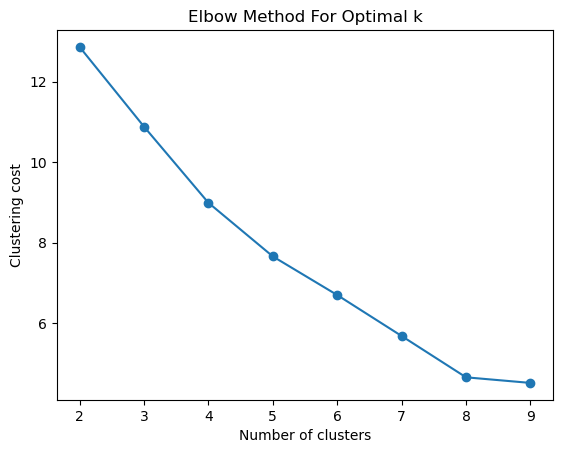

In [151]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from kmodes.kprototypes import KPrototypes

# Load in data
# df_summary = pd.read_csv("amyloid_summary.csv", header=0)

# Select features for clustering
num_features = [
    "Num Protofilaments",
    "Avg RMSD", 
    "Avg Tilt (°)", 
    "Avg Rise (Å)", 
    "Avg Twist (°)"
]

cat_features = [
    "ParallelOrAntiparallel",
    "InregisterOrOutregister"
]

# Normalize numerical features
scaler = MinMaxScaler()
# df_summary[num_features] = scaler.fit_transform(df_summary[num_features])
df_summary[num_features] = scaler.fit_transform(df_summary[num_features])

# Ensure categorical columns are string/object type
df_summary[cat_features] = df_summary[cat_features].astype(str)

# Combine feature list
all_features = num_features + cat_features

# Convert to NumPy array (object dtype to mix types)
X = df_summary[all_features].to_numpy(dtype=object)

# Indices of categorical columns
cat_col_idx = [all_features.index(col) for col in cat_features]

# Find the optimal number of clusters
costs = []
K = range(2, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    kproto.fit(X, categorical=cat_col_idx)
    costs.append(kproto.cost_)

# Plot elbow curve
plt.plot(K, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Clustering cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 51, ncost: 5.203519162792996
Run: 1, iteration: 2/100, moves: 7, ncost: 5.097902174225225
Run: 1, iteration: 3/100, moves: 0, ncost: 5.097902174225225
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 39, ncost: 5.119246384862062
Run: 2, iteration: 2/100, moves: 7, ncost: 4.974296643629868
Run: 2, iteration: 3/100, moves: 2, ncost: 4.907786853745298
Run: 2, iteration: 4/100, moves: 5, ncost: 4.665481875274757
Run: 2, iteration: 5/100, moves: 2, ncost: 4.660577272993024
Run: 2, iteration: 6/100, moves: 2, ncost: 4.657670684682674
Run: 2, iteration: 7/100, moves: 0, ncost: 4.657670684682674
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1

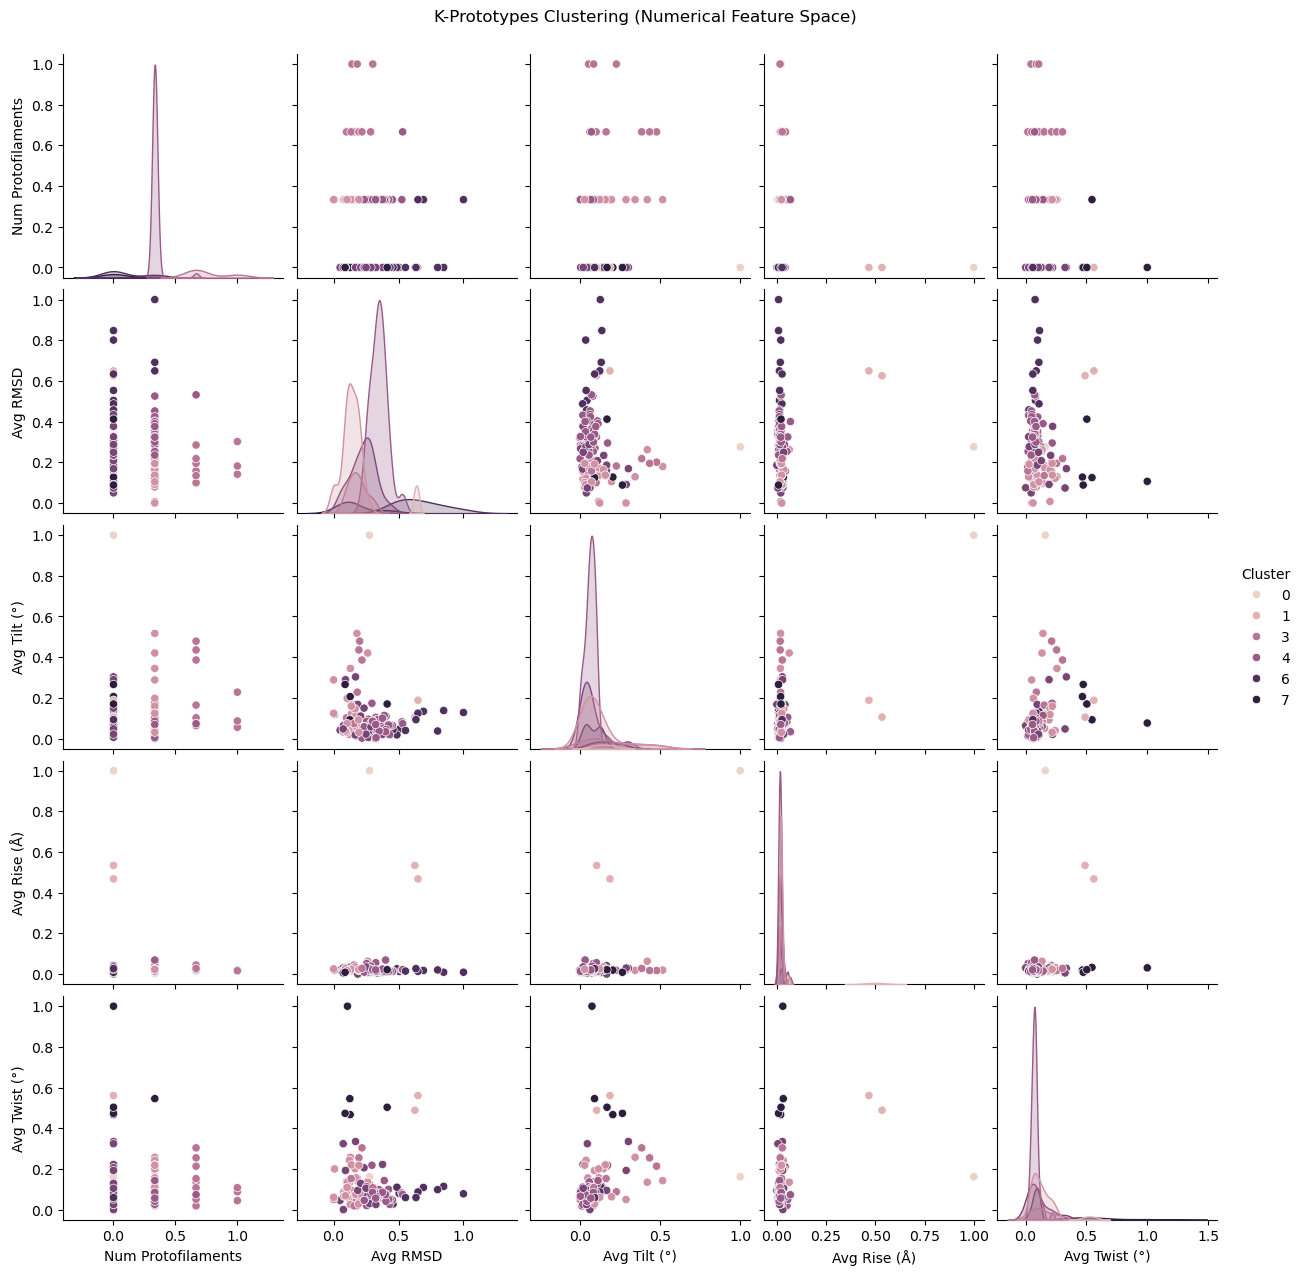

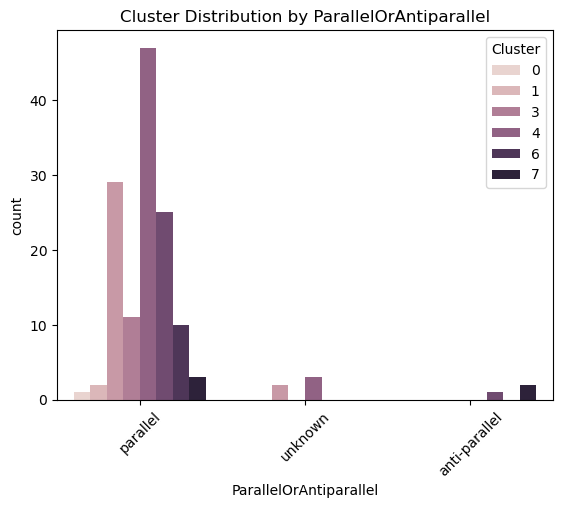

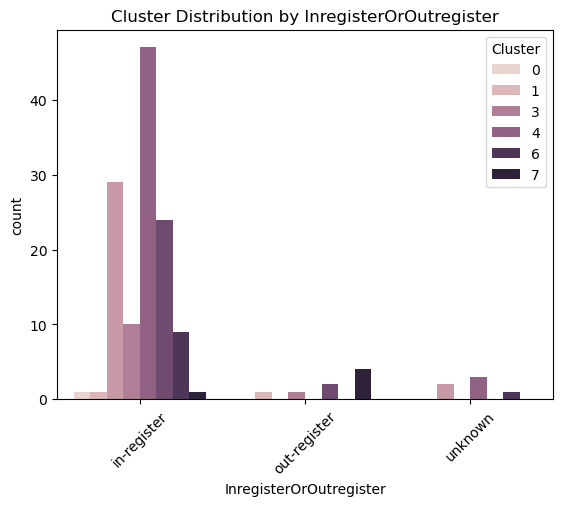

    Amyloid  Cluster
0      6r4r        6
1      2nnt        5
2      6cu7        4
3      6qjh        6
4      6vw2        2
..      ...      ...
131    7e0f        4
132    7lna        6
133    6rtb        4
134    7q4b        2
135    7l7h        3

[136 rows x 2 columns]


In [152]:
# Clustering with optmal number of clusters
kproto = KPrototypes(n_clusters=8, init='Huang', verbose=2)
clusters = kproto.fit_predict(X, categorical=cat_col_idx)

# Add cluster labels back to your DataFrame
df_summary['Cluster'] = clusters

# Visualize cluster distribution in original feature space
sns.pairplot(df_summary, hue="Cluster", vars=num_features)
plt.suptitle("K-Prototypes Clustering (Numerical Feature Space)", y=1.02)
plt.show()

# Plot Categorical Distributions
for cat in cat_features:
    plt.figure()
    sns.countplot(data=df_summary, x=cat, hue='Cluster')
    plt.title(f'Cluster Distribution by {cat}')
    plt.xticks(rotation=45)
    plt.show()

# Print clustering results
print(df_summary[["Amyloid", "Cluster"]])

In [153]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# # Scale numerical (already scaled earlier)
# scaler = MinMaxScaler()
# num_scaled = pd.DataFrame(
#     scaler.fit_transform(df_summary[num_features]),
#     columns=num_features,
#     index=df_summary.index
# )

# Encode all categories (keep all dummies for now)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None)
cat_encoded = ohe.fit_transform(df_summary[cat_features])
cat_feature_names = ohe.get_feature_names_out(cat_features)

# Create DataFrame from encoded cats
cat_encoded_df = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=df_summary.index)

# Drop any dummy columns that represent the 'unknown' catego
unknown_cols = [col for col in cat_encoded_df.columns if col.endswith('_unknown')]
cat_encoded_df = cat_encoded_df.drop(columns=unknown_cols)

# Combine
# df_encoded = pd.concat([df_summary[num_features], cat_encoded_df], axis=1)
df_encoded = pd.concat([df_summary[num_features]], axis=1)
X_umap = df_encoded.to_numpy()
features = df_encoded.columns.tolist()

np.save("X_umap.npy", X_umap)

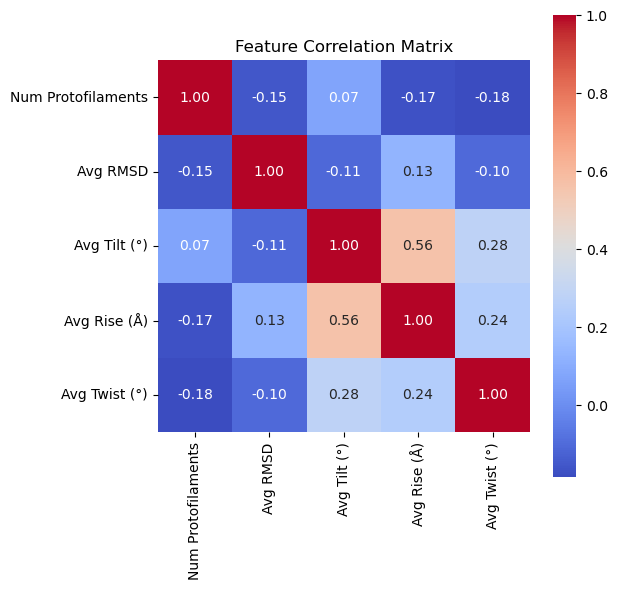

              feature       VIF
0               const  8.848315
1  Num Protofilaments  1.131447
2            Avg RMSD  1.093895
3        Avg Tilt (°)  1.645653
4        Avg Rise (Å)  1.638236
5       Avg Twist (°)  1.159766


In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix (for numerical features only)
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Subset numerical features only
X_vif = df_encoded.select_dtypes(include=[np.number]).copy()
X_vif = add_constant(X_vif)  # Add intercept term

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



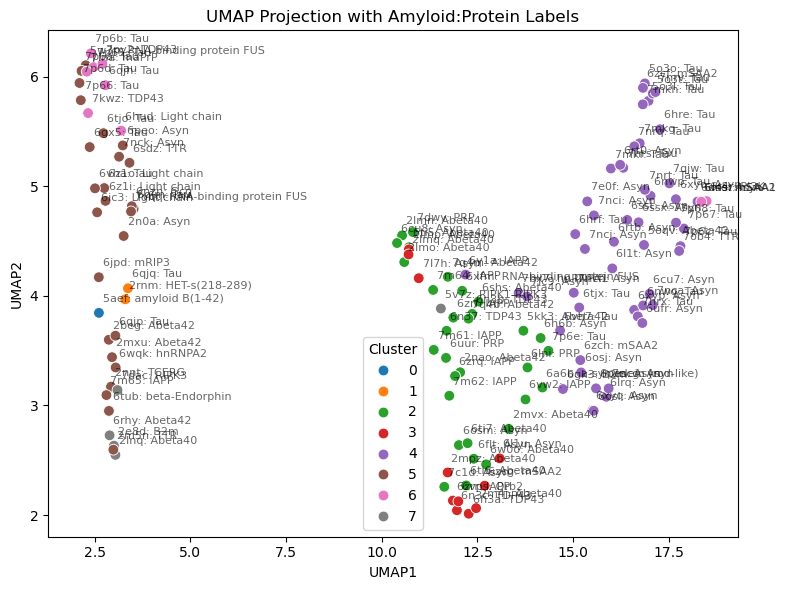

In [ ]:
# import umap.umap_ as umap
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
embedding = reducer.fit_transform(X_umap)

# Add to DataFrame
df_summary['UMAP1'] = embedding[:, 0]
df_summary['UMAP2'] = embedding[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_summary, x='UMAP1', y='UMAP2', hue='Cluster', palette="tab10", s=60)

# Add combined text labels (e.g., "Amyloid: Protein")
for i, row in df_summary.iterrows():
    label = f"{row['Amyloid']}: {row['Protein']}"
    plt.text(row['UMAP1'] + 0.1, row['UMAP2'] + 0.1, label, fontsize=8, alpha=0.6)

plt.title('UMAP Projection with KPrototypes Clusters')
plt.tight_layout()
plt.show()

## HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) Clustering

In [156]:
import pandas as pd
import umap
import hdbscan
import plotly.express as px

# Run UMAP
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=3, metric="cosine", random_state=42)
embedding = reducer.fit_transform(X_umap)

# Create DataFrame from UMAP output
embeddings = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'UMAP3': embedding[:, 2],
})

# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_umap)
embeddings['HDBSCAN_Cluster_UMAP'] = cluster_labels.astype(str)  # Convert to string for categorical coloring

# Plot with Plotly
fig = px.scatter_3d(
    embeddings,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='HDBSCAN_Cluster_UMAP',
    title='3D UMAP Projection with HDBSCAN Clusters',
    labels={'HDBSCAN_Cluster_UMAP': 'Cluster'},
    opacity=0.7
)

fig.update_traces(marker=dict(size=4))
fig.show()


/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [157]:
import pandas as pd
from sklearn.manifold import TSNE
import hdbscan
import plotly.express as px

# Run t-SNE
tsne = TSNE(n_components=3, perplexity=5, learning_rate=20, n_iter=1000, random_state=42)
embedding = tsne.fit_transform(X_umap)  # Assuming X_umap is your original high-dimensional data

# Create DataFrame from t-SNE output
embeddings = pd.DataFrame({
    'TSNE1': embedding[:, 0],
    'TSNE2': embedding[:, 1],
    'TSNE3': embedding[:, 2],
})

# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=2, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_umap)
embeddings['HDBSCAN_Cluster_TSNE'] = cluster_labels.astype(str)

# Plot with Plotly
fig = px.scatter_3d(
    embeddings,
    x='TSNE1',
    y='TSNE2',
    z='TSNE3',
    color='HDBSCAN_Cluster_TSNE',
    title='3D t-SNE Projection with HDBSCAN Clusters',
    labels={'HDBSCAN_Cluster_TSNE': 'Cluster'},
    opacity=0.7
)

fig.update_traces(marker=dict(size=4))
fig.show()

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [158]:
df_summary.head()

,Amyloid,Num Protofilaments,Avg RMSD,Avg Tilt (°),Avg Rise (Å),Avg Twist (°),Protein,Structure Title,TotalSheetLines,ParallelCount,AntiparallelCount,InRegisterCount,OutRegisterCount,ParallelOrAntiparallel,InregisterOrOutregister,Cluster,UMAP1,UMAP2
0,6r4r,0.333333,1.000000,0.127919,0.009111,0.077635,PI3K,Cryo-EM Structure of the PI3-Kinase SH3 Domain...,56,40,0,40,0,parallel,in-register,6,18.486092,4.865533
1,2nnt,0.000000,0.157873,0.166550,0.041645,0.210810,TCERG,General structural motifs of amyloid protofila...,8,6,0,0,6,parallel,out-register,5,2.926950,3.171866
2,6cu7,0.333333,0.363307,0.044683,0.019067,0.067078,Asyn,Alpha Synuclein fibril formed by full length p...,60,48,0,48,0,parallel,in-register,4,16.997469,4.019308
3,6qjh,0.000000,0.504521,0.045241,0.013549,0.079728,Tau,Cryo-EM structure of heparin-induced 2N4R tau ...,18,12,0,12,0,parallel,in-register,6,2.780905,5.923229
4,6vw2,0.333333,0.156311,0.018139,0.017319,0.078109,IAPP,Cryo-EM structure of human islet amyloid polyp...,30,24,0,24,0,parallel,in-register,2,13.754842,3.054986


### UMAP Feature Importance (Permutation Test)

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-package

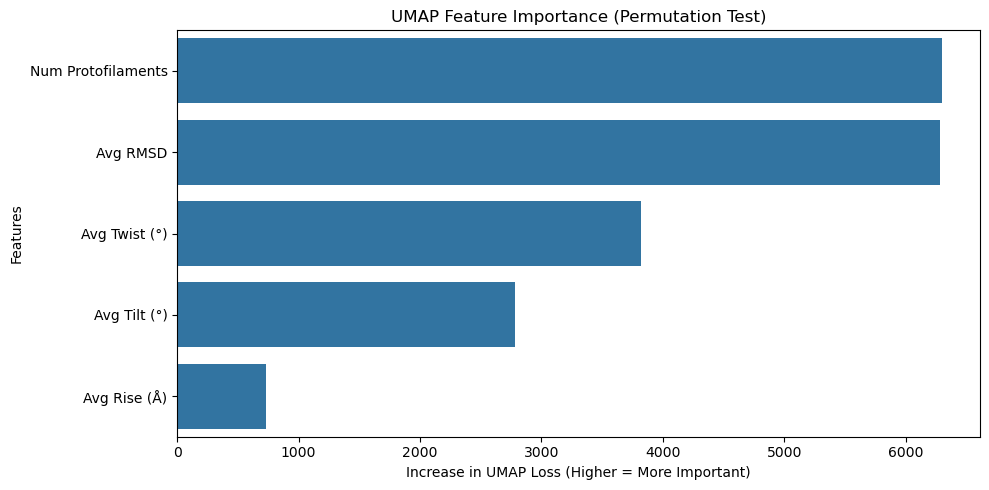

In [159]:
import numpy as np
import pandas as pd
import umap
import umap.umap_ as umap_internal

def compute_umap_cross_entropy_loss(X, embedding, n_neighbors=10, random_state=42):
    # Fit UMAP on original input to get high-dimensional fuzzy graph
    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=random_state)
    reducer.fit(X)
    graph_hd = reducer.graph_.tocoo()

    # Get low-dimensional fuzzy graph from embedding
    graph_ld = umap_internal.fuzzy_simplicial_set(
        X=embedding,
        n_neighbors=n_neighbors,
        random_state=np.random.RandomState(random_state),
        metric='euclidean',
        angular=False
    )[0].tocoo()

    # Build dicts for quick lookup
    hd_dict = {(i, j): v for i, j, v in zip(graph_hd.row, graph_hd.col, graph_hd.data)}
    ld_dict = {(i, j): v for i, j, v in zip(graph_ld.row, graph_ld.col, graph_ld.data)}

    # Compute cross-entropy loss
    loss = 0.0
    eps = 1e-8
    for (i, j), hd_val in hd_dict.items():
        ld_val = ld_dict.get((i, j), 0.0)
        loss += (
            hd_val * np.log((hd_val + eps) / (ld_val + eps)) +
            (1 - hd_val) * np.log((1 - hd_val + eps) / (1 - ld_val + eps))
        )
    return loss

# Baseline embedding and loss
baseline_reducer = umap.UMAP(n_neighbors=10, random_state=42)
baseline_embedding = baseline_reducer.fit_transform(X_umap)
baseline_loss = compute_umap_cross_entropy_loss(X_umap, baseline_embedding)

# Permutation importance
feature_importance = []
rng = np.random.default_rng(42)

for feature in features:
    X_permuted = X_umap.copy()
    idx = features.index(feature)

    # Permute the feature
    X_permuted[:, idx] = rng.permutation(X_permuted[:, idx])

    # Fit UMAP on permuted data
    reducer = umap.UMAP(n_neighbors=10, random_state=42)
    embedding_permuted = reducer.fit_transform(X_permuted)

    # Compute cross-entropy loss
    permuted_loss = compute_umap_cross_entropy_loss(X_umap, embedding_permuted)
    importance = permuted_loss - baseline_loss
    feature_importance.append(importance)

# Output importance as a sorted Series
importance_series = pd.Series(feature_importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importance_series.values, y=importance_series.index)
plt.title("UMAP Feature Importance (Permutation Test)")
plt.xlabel("Increase in UMAP Loss (Higher = More Important)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

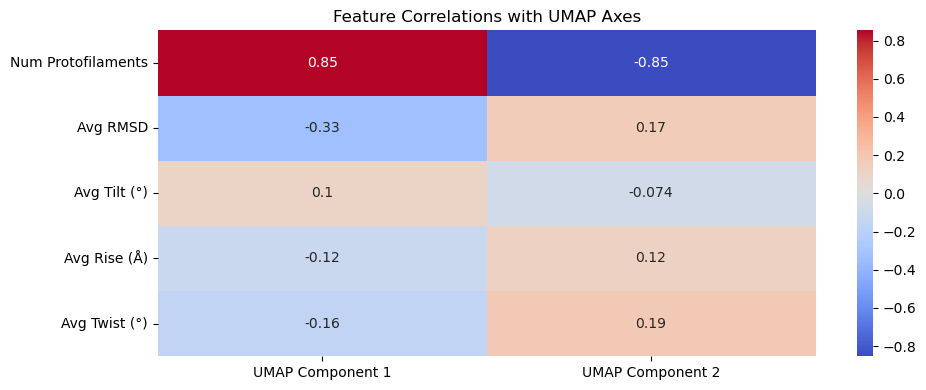

In [160]:
import pandas as pd

# Ensure 'X_umap' is a DataFrame
X_umap_df = pd.DataFrame(X_umap, columns=[f"UMAP Component {i+1}" for i in range(X_umap.shape[1])])

# Calculate the correlation between each feature and each UMAP component
correlations = []
for component in range(baseline_embedding.shape[1]):  # Loop over UMAP components (2D or 3D)
    # Convert the UMAP component to a pandas Series for correlation calculation
    umap_component = pd.Series(baseline_embedding[:, component], name=f"UMAP Component {component+1}")
    
    # Compute correlation with each feature column in X_umap_df
    corr = X_umap_df.corrwith(umap_component)
    correlations.append(corr)

# Convert correlations to DataFrame for better readability
correlation_df = pd.DataFrame(correlations)
correlation_df.columns = features  # Set original feature names as columns
correlation_df.index = [f"UMAP Component {i+1}" for i in range(baseline_embedding.shape[1])]

# Plot Feature Correlation Heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlations with UMAP Axes")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



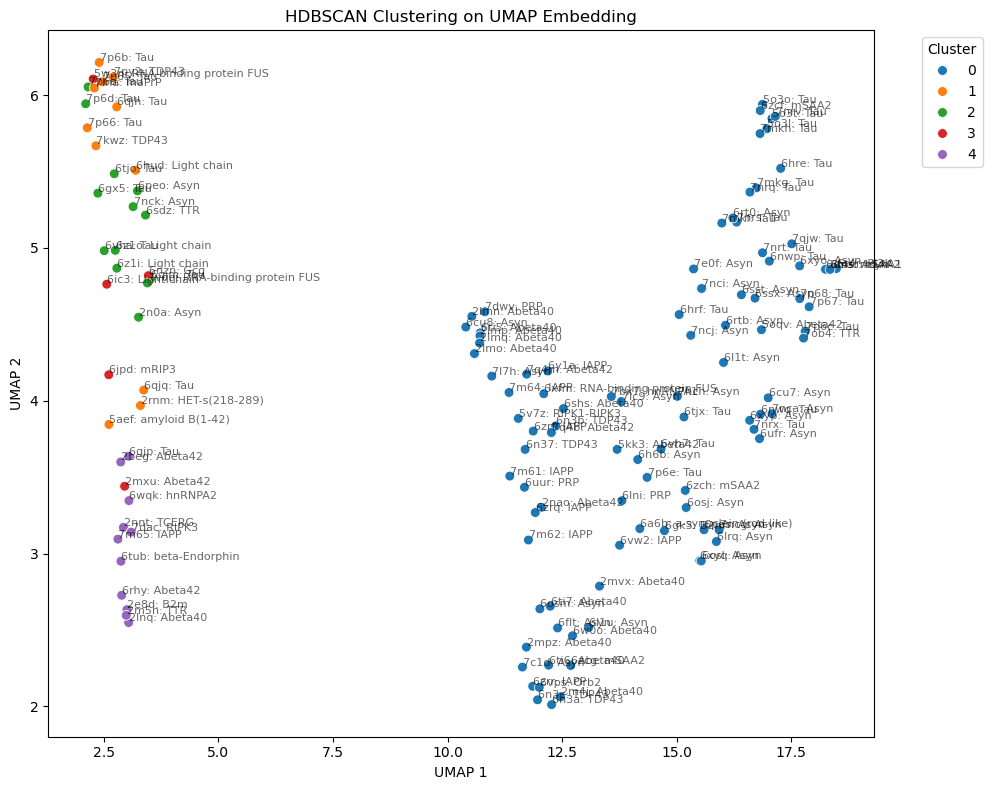

In [161]:
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `baseline_embedding` is your 2D UMAP output
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, prediction_data=True)
cluster_labels = clusterer.fit_predict(baseline_embedding)

# Add cluster labels to your original DataFrame for further analysis
df_summary['HDBSCAN_Cluster_UMAP'] = cluster_labels

# Plot UMAP with cluster assignments
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(np.unique(cluster_labels)))
sns.scatterplot(x=df_summary['UMAP1'], y=df_summary['UMAP2'],
                hue=cluster_labels, palette=palette, s=50)

# Add combined text labels (e.g., "Amyloid: Protein")
for i, row in df_summary.iterrows():
    label = f"{row['Amyloid']}: {row['Protein']}"
    plt.text(row['UMAP1'] + 0.01, row['UMAP2'] + 0.01, label, fontsize=8, alpha=0.6)

plt.title("HDBSCAN Clustering on UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [162]:
# Numeric summary
# Ensure you're using only columns that were originally scaled
numeric_cols = ['Num Protofilaments', 'Avg RMSD', 'Avg Tilt (°)', 'Avg Rise (Å)', 'Avg Twist (°)']
scaled_data = df_summary[numeric_cols]

# Invert scaling
inversed_data = pd.DataFrame(
    scaler.inverse_transform(scaled_data),
    columns=numeric_cols,
    index=df_summary.index
)

# Add cluster labels back
inversed_data['HDBSCAN_Cluster_UMAP'] = df_summary['HDBSCAN_Cluster_UMAP']

# Group and compute mean
numeric_summary = inversed_data.groupby("HDBSCAN_Cluster_UMAP").mean()

# Categorical summary (most frequent category)
categorical_cols = ['HDBSCAN_Cluster_UMAP', 'ParallelOrAntiparallel', 'InregisterOrOutregister']
categorical_summary = df_summary[categorical_cols].groupby("HDBSCAN_Cluster_UMAP")[
    ['ParallelOrAntiparallel', 'InregisterOrOutregister']
].agg(lambda x: x.value_counts().index[0])

# Combine
cluster_summary = pd.concat([numeric_summary, categorical_summary], axis=1)
cluster_summary.head(10)

,Num Protofilaments,Avg RMSD,Avg Tilt (°),Avg Rise (Å),Avg Twist (°),ParallelOrAntiparallel,InregisterOrOutregister
HDBSCAN_Cluster_UMAP,,,,,,,
0,2.15625,1.003997,9.522423,4.850339,1.461530,parallel,in-register
1,1.00000,2.119838,14.980479,6.670599,2.378355,parallel,in-register
2,1.00000,1.057348,4.214044,4.819241,1.134480,parallel,in-register
3,1.00000,0.473135,3.970260,4.853211,0.512856,parallel,in-register
4,1.00000,0.626602,16.434224,4.846186,5.169086,parallel,in-register


/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/envs/amyloid/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



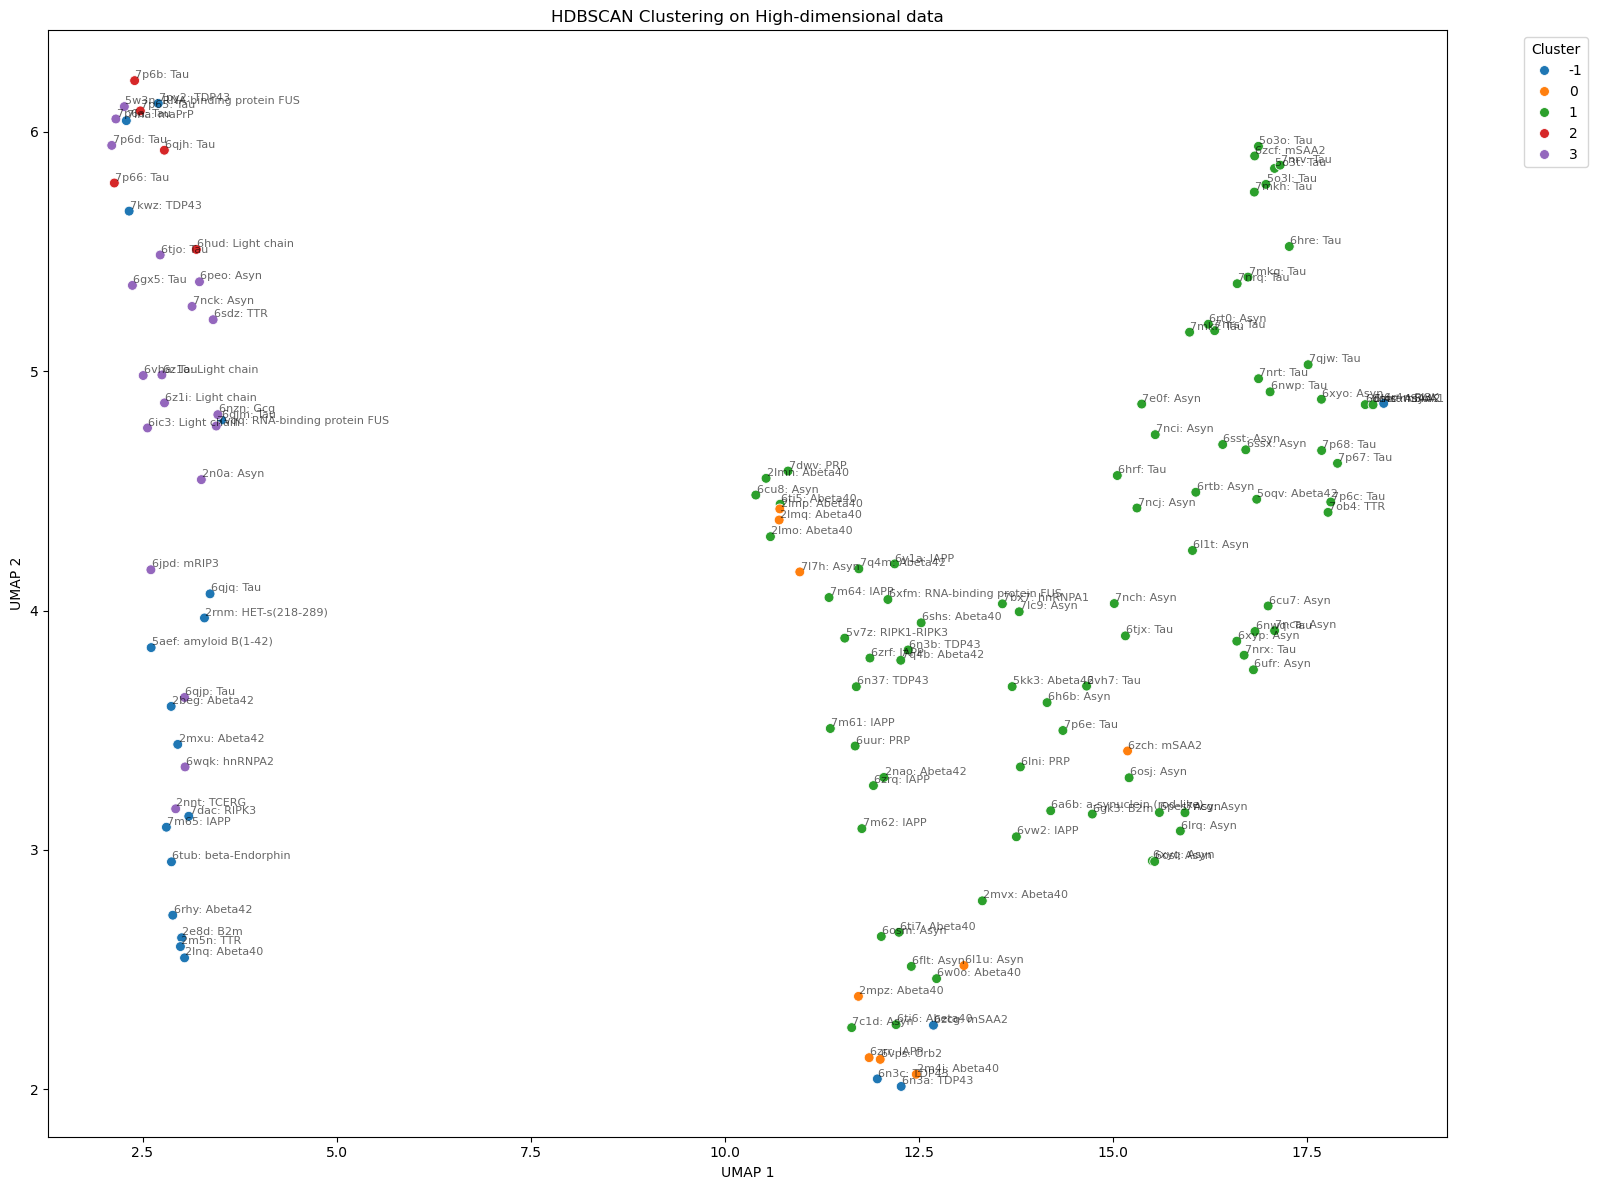

In [163]:
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `baseline_embedding` is your 2D UMAP output
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_umap)

# Add cluster labels to your original DataFrame for further analysis
df_summary['HDBSCAN_Cluster_high_dim'] = cluster_labels

# Plot UMAP with cluster assignments
plt.figure(figsize=(16, 12))
palette = sns.color_palette("tab10", len(np.unique(cluster_labels)))
sns.scatterplot(x=df_summary['UMAP1'], y=df_summary['UMAP2'],
                hue=cluster_labels, palette=palette, s=50)

# Add combined text labels (e.g., "Amyloid: Protein")
for i, row in df_summary.iterrows():
    label = f"{row['Amyloid']}: {row['Protein']}"
    plt.text(row['UMAP1'] + 0.01, row['UMAP2'] + 0.01, label, fontsize=8, alpha=0.6)

plt.title("HDBSCAN Clustering on High-dimensional data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()